#### Set up

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.windows import Window
import rasterio.plot
from pyproj import Transformer
import json
from utils import crop_tiles, get_tile_path

# Churchill
pan_dir = r'E:\2022\Churchill_050166593010 & 050169967010\050169967010_01\050169967010_01_'
whale_shp_path = r'E:\annotations_fmt\Churchill_2022_fmt.shp'
crop_size = 320
cropped_images_dir=f'crops_Churchill_{crop_size}'
dataSource = "WorldView-3"

# # ClearWater 2022
# pan_dir = r'E:\2022\Clearwater&Kangilo_015379185020_01\015379185020_01_P001_PAN_MOS'
# whale_shp_path = r'E:\annotations_fmt\Clearwater_2022_fmt.shp'
# crop_size = 192
# cropped_images_dir=f'crops_CW22_{crop_size}'
# dataSource = "WorldView-2"

# # ClearWater 2021
# pan_dir = r'D:\Whale_Data\2021\Clearwater\014413001050_01_'
# whale_shp_path = r'E:\annotations_fmt\Clearwater_2021_fmt.shp'
# crop_size = 320
# cropped_images_dir=f'crops_CW21_{crop_size}'
# dataSource = "WorldView-3"

metadata_path = os.path.join(cropped_images_dir, 'metadata.json')
whale_gdf = gpd.read_file(whale_shp_path)

print(f"The coordinate system of shp file is {whale_gdf.crs.to_string()}.")
print(f'Number of annotations: {len(whale_gdf)}')
print('The geometry of the first object:', whale_gdf.geometry.iloc[0].wkt)
whale_gdf.head()

The coordinate system of shp file is EPSG:4326.
Number of annotations: 491
The geometry of the first object: POINT (-94.27630190999997 58.85347278000006)


,ORIG_FID,length,location,population,Year,date,conf_detec,conf_measu,conf_vecto,social_gro,Longitude,Latitude,Strip_ID,ID,Photo-ID,Species,geometry
0,1,2.830853,Churchill River,Western Hudson Bay,2022,31072022,2,3,1,A,-94.276302,58.853473,P001,1,22JUL31174054-P3DS_R1C1-050169967010_01_P001,certain whale,POINT (-94.2763 58.85347)
1,2,1.722982,Churchill River,Western Hudson Bay,2022,31072022,1,1,1,B,-94.245892,58.846111,P001,2,22JUL31174054-P3DS_R1C1-050169967010_01_P001,uncertain whale,POINT (-94.24589 58.84611)
2,4,2.330208,Churchill River,Western Hudson Bay,2022,31072022,2,2,1,C,-94.195673,58.766100,P001,3,22JUL31174054-P3DS_R3C2-050169967010_01_P001,certain whale,POINT (-94.19567 58.7661)
3,5,1.248322,Churchill River,Western Hudson Bay,2022,31072022,1,1,0,D,-94.272695,58.853545,P001,4,22JUL31174054-P3DS_R1C1-050169967010_01_P001,uncertain whale,POINT (-94.27269 58.85355)
4,6,1.943017,Churchill River,Western Hudson Bay,2022,31072022,2,1,1,E,-94.219046,58.813316,P001,5,22JUL31174054-P3DS_R2C1-050169967010_01_P001,certain whale,POINT (-94.21905 58.81332)


In [2]:
# Step 1: Identify the tiles that include targets using the 'Photo-ID' column
tiles_with_targets = whale_gdf['Photo-ID'].unique()
tiles_with_targets = tiles_with_targets[tiles_with_targets != None]

# Step 2: Group by 'Photo-ID' and list target IDs
tiles_to_targets = whale_gdf.groupby('Photo-ID')['ID'].apply(list)
print("Tiles to Target IDs Mapping:")
for tile, target_ids in tiles_to_targets.items():
    print(f"Tile: {tile}, Target IDs: {target_ids}")

Tiles to Target IDs Mapping:
Tile: 22JUL31174035-P3DS_R3C1-050169967010_01_P002, Target IDs: [419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491]
Tile: 22JUL31174054-P3DS_R1C1-050169967010_01_P001, Target IDs: [1, 2, 4]
Tile: 22JUL31174054-P3DS_R2C1-050169967010_01_P001, Target IDs: [5, 6, 7, 8, 9, 10, 11, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 80, 81, 82, 83, 84, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 297, 298, 299, 300, 301, 328, 416, 417]
Tile: 22JUL31174054-P3DS_R2C2-05016

#### Visualize crop windows

Tile: 22JUL31174054-P3DS_R1C1-050169967010_01_P001
Size: 16384 x 16384
Bounds: BoundingBox(left=425246.39999999997, bottom=6521143.199999999, right=430161.6, top=6526058.399999999)
----------
annotation_crs: EPSG:4326 raster_crs: EPSG:32615
426365.0448148055 6524438.268504069
428104.1148481659 6523585.532358323
426573.30663701415 6524442.353263798


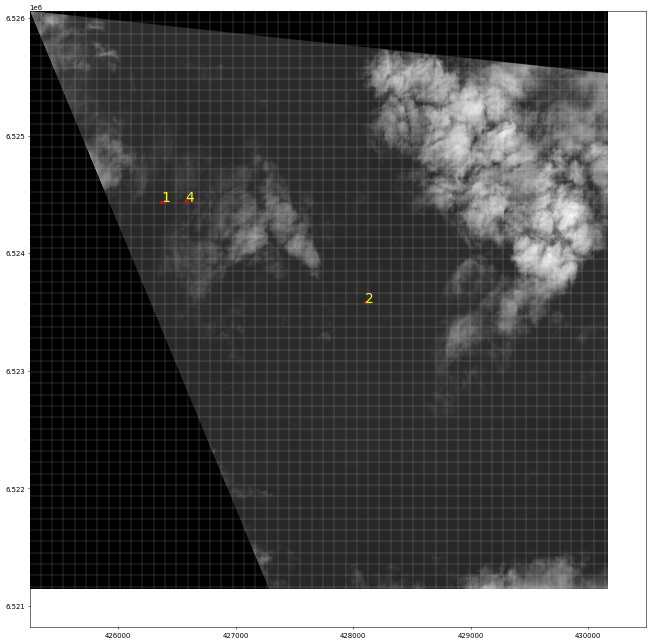

In [3]:
# Step 3: Iterate through the tiles containing whales, read each tile, and print the size of the imagery
dpi = 50

for tile in tiles_with_targets:
    pan_path = get_tile_path(pan_dir, tile)
    if os.path.exists(pan_path):
        with rasterio.open(pan_path) as src:
            print(f"Tile: {tile}")
            print(f"Size: {src.width} x {src.height}")
            print(f"Bounds: {src.bounds}")
            print("----------")
            # Step 4: Visualize the imagery using Matplotlib
            fig, ax = plt.subplots(figsize=(16, 16), dpi=dpi)
            rasterio.plot.show(src, ax=ax, cmap='gray')
            
            raster_crs = src.crs
            whale_crs = whale_gdf.crs
            print(f'annotation_crs: {whale_crs.to_string()}', f'raster_crs: {raster_crs.to_string()}')
            transformer = Transformer.from_crs(whale_crs, raster_crs, always_xy=True)

            whale_positions = whale_gdf[whale_gdf['Photo-ID'] == tile]
            for _, whale in whale_positions.iterrows():
                geom = whale.geometry
                if not geom.is_empty:
                    # Convert whale geometry to raster coordinates
                    x, y = transformer.transform(geom.x, geom.y)
                    row, col = x, y
                    print(row, col)
                    ax.plot(row, col, marker='.', color='red', markersize=8, alpha=1)
                    ax.text(row, col, str(whale['ID']), color='yellow', fontsize=20)
            
            # Create grid windows
            for row_start in range(0, src.height, crop_size):
                for col_start in range(0, src.width, crop_size):
                    window = Window(col_start, row_start, crop_size, crop_size)
                    window_bounds = src.window_bounds(window)
                    
                    # Unpack window_bounds
                    left, bottom, right, top = window_bounds
                    
                    # Plot grid windows
                    rect = plt.Rectangle((left, bottom),
                                         right - left,
                                         top - bottom,
                                         edgecolor='white', facecolor='none', linewidth=0.25, alpha=0.5)
                    ax.add_patch(rect)
            
    else:
        print(f"Tile file {pan_path} not found in directory {pan_dir}.")
    break  # Remove this break if you want to process all tiles

#### Crop

In [4]:
crop_tiles(tiles_with_targets, pan_dir, whale_gdf, dataSource, crop_size=crop_size,
           output_dir=cropped_images_dir, metadata_path=metadata_path, append=False)

Tile: 22JUL31174054-P3DS_R1C1-050169967010_01_P001  Size: 16384 x 16384
Bounds: BoundingBox(left=425246.39999999997, bottom=6521143.199999999, right=430161.6, top=6526058.399999999)
5400 3728
8242 9525
5386 4423
Tile: 22JUL31174054-P3DS_R3C2-050169967010_01_P001  Size: 11188 x 6018
Bounds: BoundingBox(left=430161.5999999999, bottom=6514422.6, right=433517.99999999994, top=6516228.0)
5344 2270
196 6757
400 6571
403 6570
1924 1030
1829 1059
1695 1484
1925 7104
2011 7187
2365 7707
2188 7191
2358 261
2368 267
2392 275
2370 243
2375 243
2374 248
3149 474
3152 467
3150 479
3006 416
3283 1739
3105 1778
4474 2664
3873 2479
3872 2471
4150 1500
4157 1505
3892 1355
3896 1368
3850 1384
3810 1377
3809 1380
3763 1361
3716 1303
3711 1296
3689 1290
3676 1285
4182 870
3796 750
3815 489
4473 133
4954 343
4951 344
5160 680
5347 833
5200 1150
5202 1149
5390 1167
5362 1272
5336 1316
5329 1324
5325 1340
5292 1275
5297 1328
5226 1143
5224 1132
4841 1163
4795 1079
4788 1063
4740 1312
5115 1272
5077 1302
5074 

#### Visualize the cropped images

reading file from ./crops_Churchill_320\metadata.json
No. 191, uncertain whale


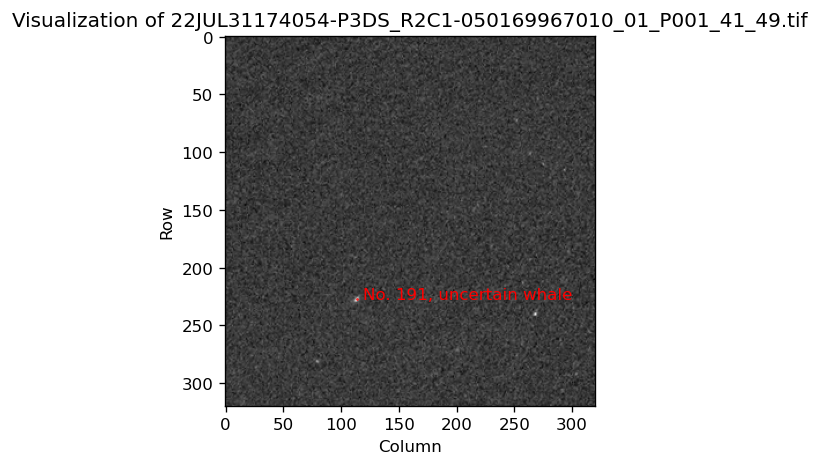

No. 122, certain whale
No. 123, certain whale


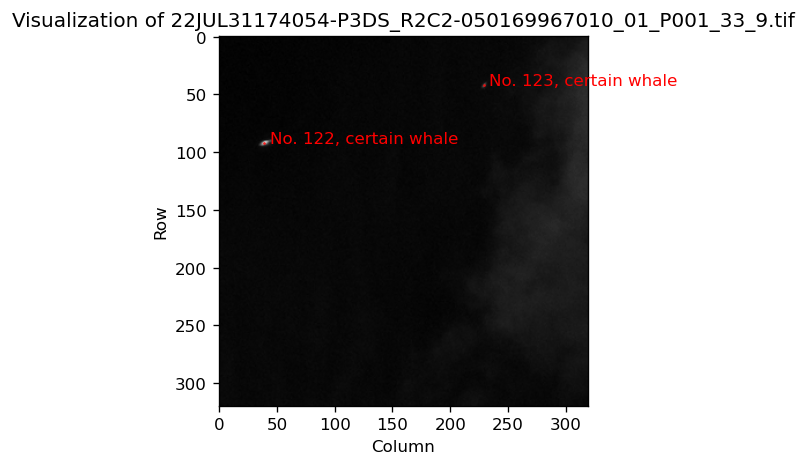

No. 129, certain whale
No. 130, certain whale
No. 131, certain whale


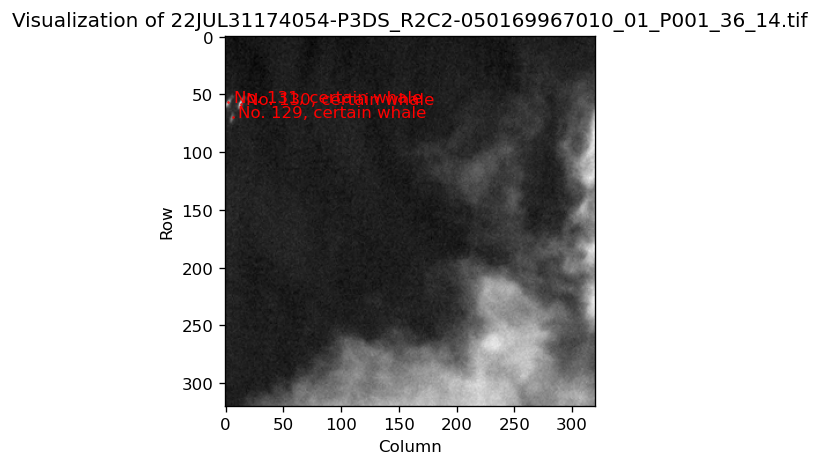

No. 239, uncertain whale


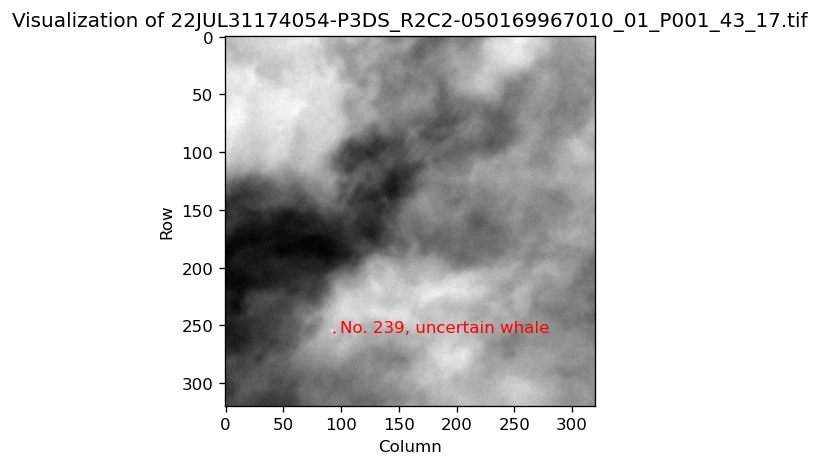

No. 329, certain whale


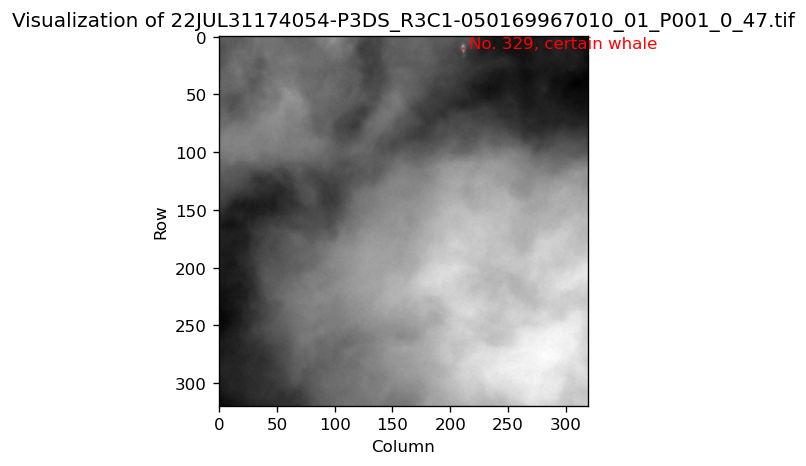

No. 441, certain whale
No. 445, certain whale


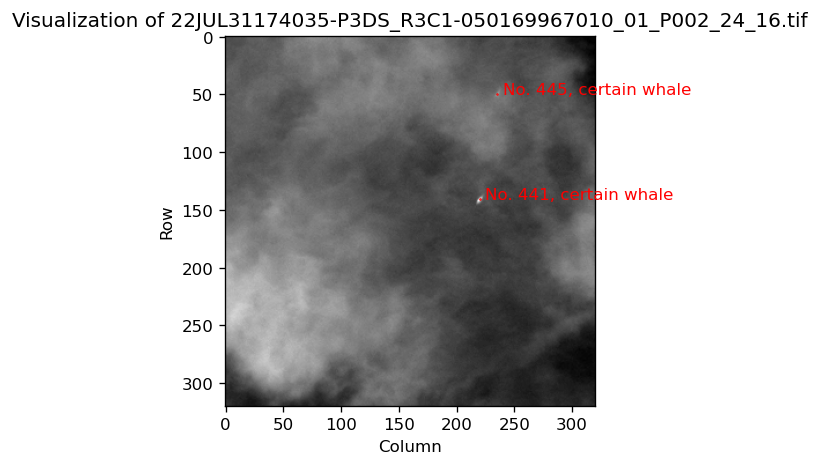

In [6]:
import random
random.seed(40)

print('reading file from', f'./{metadata_path}')
with open(metadata_path, 'r') as json_file:
    metadata = json.load(json_file)

# Iterate through all tiles in the metadata
for tile in metadata['tiles']:
    tile_url = tile['tileURL']
    tile_metadata_path = os.path.join(cropped_images_dir, tile_url)
    for window in tile['windows']:
        cropped_image_path = os.path.join(cropped_images_dir, window['dataURL'])
        if not os.path.exists(cropped_image_path):
            print(f"Cropped file {window['dataURL']} not found in directory {cropped_images_dir}.")
            continue
        
        # randomly skip 90% of the images
        if random.random() > 0.02:
            continue
        # Read the cropped image
        with rasterio.open(cropped_image_path) as src:
            crop_image = src.read(1)
            # Plot the cropped image
            plt.figure(figsize=(4, 4), dpi=120)
            plt.imshow(crop_image, cmap='gray')
            plt.title(f"Visualization of {os.path.basename(cropped_image_path)}")

            # Plot the object points
            for label in window['labels']:
                point_row, point_col = label['pointIndex']
                plt.plot(point_col, point_row, marker='o', color='red', markersize=0.5)
                plt.text(point_col+5, point_row, f'No. {label["originID"]}, {label["class"]}', color='red', fontsize=10)
                print(f'No. {label["originID"]}, {label["class"]}')
            
            plt.xlabel('Column')
            plt.ylabel('Row')
            plt.show()